# Time series forecasting using Recurrent Neural Networks (RNNs).

Let's first extract only the 'cases ' from the dataset. Let's observe how this data looks across time.

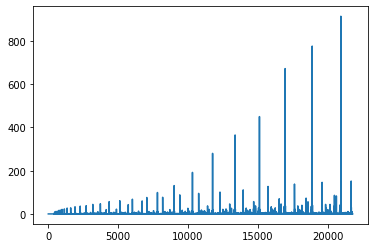

In [6]:
import os
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('C:\\Users\\Mirela\\PycharmProjects\\Covid_19\\us-counties.csv',
                      usecols=[5]).values.astype('float64')

from matplotlib import pyplot as plt

cases = dataset[:, 0] 

plt.plot(range(len(cases)), cases)

In [7]:
# Helper function to get y as a numpy array from the TimeseriesGenerator
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

The first 16,000 rows of the data will be the training dataset, and there remaining will be the validation  and  test dataset .
It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.
The model will be given the last 100 recorded 'cases' observations, and needs to learn to predict the cases at the next time step.

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets

train, val, test = dataset[0:16000, :], dataset[16001:17000, :], dataset[17001:None, :]

lookback = 100
step = 1
batch_size = 128

train_data_gen = TimeseriesGenerator(train, train,
                                     length=lookback, sampling_rate=step, stride=1,shuffle=True,
                                     batch_size=batch_size)

val_data_gen = TimeseriesGenerator(val, val,
                                   length=lookback, sampling_rate=step, stride=1,
                                   batch_size=batch_size)

test_data_gen = TimeseriesGenerator(test, test,
                                    length=lookback, sampling_rate=step, stride=1,
                                    batch_size=batch_size)

val_steps = (17000 - 16001 - lookback)
test_steps = (len(dataset) - 17001 - lookback)

I  will train a model using only a single feature (cases), and use it to make predictions for that value in the future.

Epoch 1/10
200/200 [==============================] - 30s 149ms/step - loss: 0.0029 - val_loss: 5.0266e-04
Epoch 2/10
200/200 [==============================] - 33s 166ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/10
200/200 [==============================] - 36s 179ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/10
200/200 [==============================] - 35s 176ms/step - loss: 9.9826e-04 - val_loss: 0.0017
Epoch 5/10
200/200 [==============================] - 35s 176ms/step - loss: 9.2681e-04 - val_loss: 0.0082
Epoch 6/10
200/200 [==============================] - 36s 178ms/step - loss: 9.5639e-04 - val_loss: 0.0013
Epoch 7/10
200/200 [==============================] - 32s 162ms/step - loss: 9.1856e-04 - val_loss: 0.0019
Epoch 8/10
200/200 [==============================] - 35s 175ms/step - loss: 8.5470e-04 - val_loss: 7.4012e-04
Epoch 9/10
200/200 [==============================] - 34s 171ms/step - loss: 9.3828e-04 - val_loss: 7.7324e-04
Epoch 10/10
200/200 [================

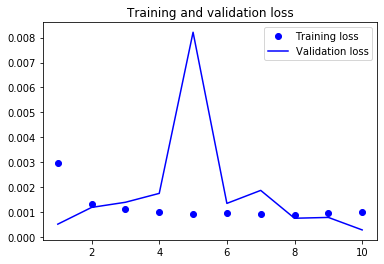

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2,input_shape=(None, dataset.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_data_gen,steps_per_epoch=200,epochs=10,validation_data=val_data_gen,
validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

test loss: 0.002092010108754039
(4698, 1)
Test Score: 18.28 RMSE


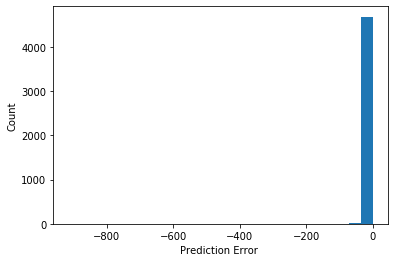

In [10]:
test_loss = model.evaluate_generator(test_data_gen,steps=test_steps)
print('test loss:', test_loss)

testPredict = model.predict_generator(test_data_gen)
testPredict.shape

testPredict = scaler.inverse_transform(testPredict)

testY = get_y_from_generator(test_data_gen)


testY = scaler.inverse_transform(testY)

from sklearn.metrics import mean_squared_error
import math
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# error distribution
error = testPredict - testY
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
_ = plt.ylabel("Count")